In [1]:
# 🔧 INSTALLATION CELL - Run this first if packages are not installed
# Updated for modern Python versions (3.11+ recommended)

# For pip users (Python 3.10+):
# !pip install torch>=2.1.0 torchvision>=0.16.0 matplotlib>=3.8.0 numpy>=1.25.2 ipywidgets>=8.1.0 tqdm>=4.66.0 pillow>=10.0.0 scikit-learn>=1.3.0

# For conda users (recommended - choose your Python version):
# Python 3.11 (recommended):
# !conda install pytorch torchvision matplotlib numpy jupyter ipykernel tqdm pillow scikit-learn ipywidgets python=3.11 -c pytorch -c conda-forge -y

# Python 3.12 (latest):
# !conda install pytorch torchvision matplotlib numpy jupyter ipykernel tqdm pillow scikit-learn ipywidgets python=3.12 -c pytorch -c conda-forge -y

print("📦 Installation cell ready!")
print("💡 Uncomment the appropriate installation command above if you need to install packages")
print("🎯 For best results, use the provided conda environment files:")
print("   • environment.yml (Python 3.11) - Recommended")
print("   • environment-py312.yml (Python 3.12) - Latest")

import sys
print(f"🐍 Current Python version: {sys.version}")

📦 Installation cell ready!
💡 Uncomment the appropriate installation command above if you need to install packages
🎯 For best results, use the provided conda environment files:
   • environment.yml (Python 3.11) - Recommended
   • environment-py312.yml (Python 3.12) - Latest
🐍 Current Python version: 3.11.13 | packaged by conda-forge | (main, Jun  4 2025, 14:52:34) [Clang 18.1.8 ]


# 1. Introduction to PGD (Projected Gradient Descent) Attacks

## 🎯 Learning Objectives

By the end of this notebook, you will understand:
- What adversarial examples are and why they matter
- The mathematical foundation of PGD attacks
- How PGD relates to FGSM (Fast Gradient Sign Method)
- The concept of epsilon balls and constraint projection
- Interactive parameter exploration

## ⚠️ Ethical Use Notice

This educational material is designed for:
- **Defensive security research** - Understanding vulnerabilities to build better defenses
- **Academic learning** - Educational purposes in adversarial ML courses
- **Model robustness evaluation** - Testing your own models

Please use responsibly and ethically! 🛡️

In [3]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML, Image as IPImage
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Configure matplotlib
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

print("🚀 Environment setup complete!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

🚀 Environment setup complete!
PyTorch version: 2.1.0
CUDA available: False


## 1.1 What are Adversarial Examples?

**Adversarial examples** are inputs to machine learning models that have been intentionally designed to cause the model to make a mistake. These inputs are created by adding small, often imperceptible perturbations to legitimate inputs.

### Key Characteristics:
- **Imperceptible to humans** - The changes are so small that humans can't notice them
- **Fool machine learning models** - Cause confident misclassifications
- **Transferable** - Often work across different models
- **Security implications** - Can be used to attack ML systems in production

### Example:
```
Original Image: 🐕 (Dog) → Model predicts: "Dog" (99% confidence)
      ↓ + tiny noise
Adversarial Image: 🐕 (Still looks like dog to humans) → Model predicts: "Cat" (95% confidence)
```

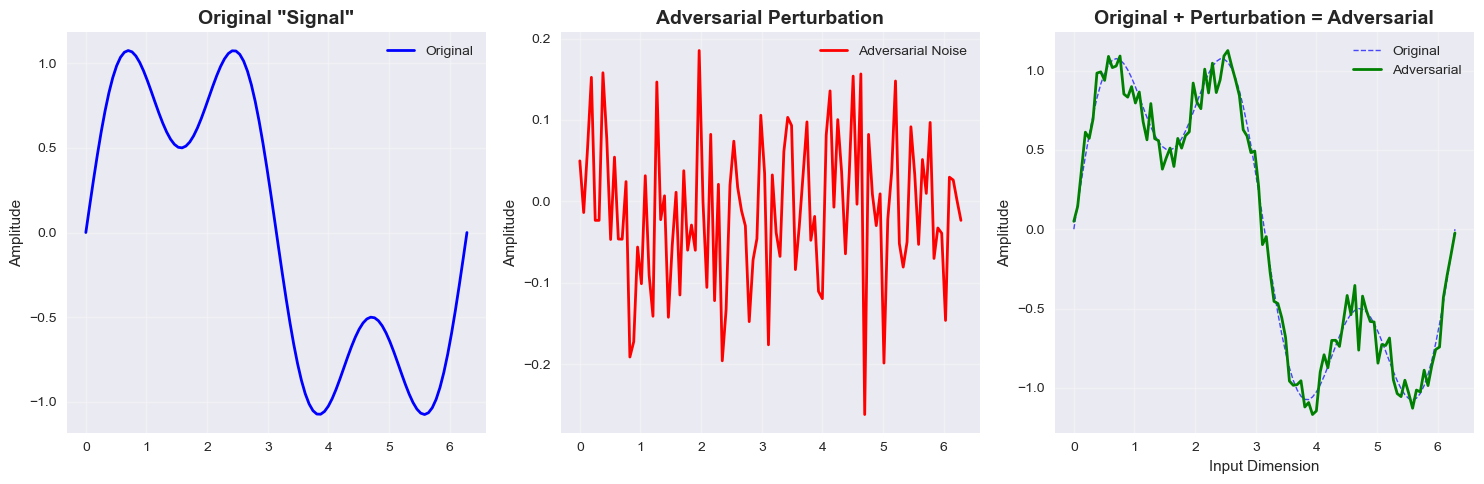

📊 Conceptual visualization of adversarial examples:
• Left: Original clean input
• Middle: Small adversarial perturbation
• Right: Adversarial example (original + perturbation)


In [4]:
# Let's create a simple visualization of the adversarial example concept
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Create synthetic "image" data for demonstration
x = np.linspace(0, 2*np.pi, 100)
original_signal = np.sin(x) + 0.5 * np.sin(3*x)
noise = 0.1 * np.random.randn(100)
adversarial_signal = original_signal + noise

# Original signal
axes[0].plot(x, original_signal, 'b-', linewidth=2, label='Original')
axes[0].set_title('Original "Signal"', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Amplitude')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# Noise
axes[1].plot(x, noise, 'r-', linewidth=2, label='Adversarial Noise')
axes[1].set_title('Adversarial Perturbation', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Amplitude')
axes[1].grid(True, alpha=0.3)
axes[1].legend()

# Adversarial signal
axes[2].plot(x, original_signal, 'b--', alpha=0.7, linewidth=1, label='Original')
axes[2].plot(x, adversarial_signal, 'g-', linewidth=2, label='Adversarial')
axes[2].set_title('Original + Perturbation = Adversarial', fontsize=14, fontweight='bold')
axes[2].set_ylabel('Amplitude')
axes[2].set_xlabel('Input Dimension')
axes[2].grid(True, alpha=0.3)
axes[2].legend()

plt.tight_layout()
plt.show()

print("📊 Conceptual visualization of adversarial examples:")
print("• Left: Original clean input")
print("• Middle: Small adversarial perturbation")
print("• Right: Adversarial example (original + perturbation)")

## 1.2 Mathematical Foundation

### The Optimization Problem

Creating adversarial examples is fundamentally an **optimization problem**. We want to find the smallest perturbation $\delta$ that causes misclassification:

$$\text{minimize} \quad ||\delta||_p \quad \text{subject to} \quad f(x + \delta) \neq f(x)$$

Where:
- $x$ is the original input
- $\delta$ is the perturbation we add
- $f(\cdot)$ is the model's prediction function
- $||\cdot||_p$ is the $L_p$ norm (commonly $L_\infty$ or $L_2$)

### Constraint-based Formulation

In practice, we often fix a budget $\epsilon$ and try to maximize the loss:

$$\text{maximize} \quad \mathcal{L}(f(x + \delta), y) \quad \text{subject to} \quad ||\delta||_p \leq \epsilon$$

Where:
- $\mathcal{L}$ is the loss function (e.g., cross-entropy)
- $y$ is the true label
- $\epsilon$ is our perturbation budget

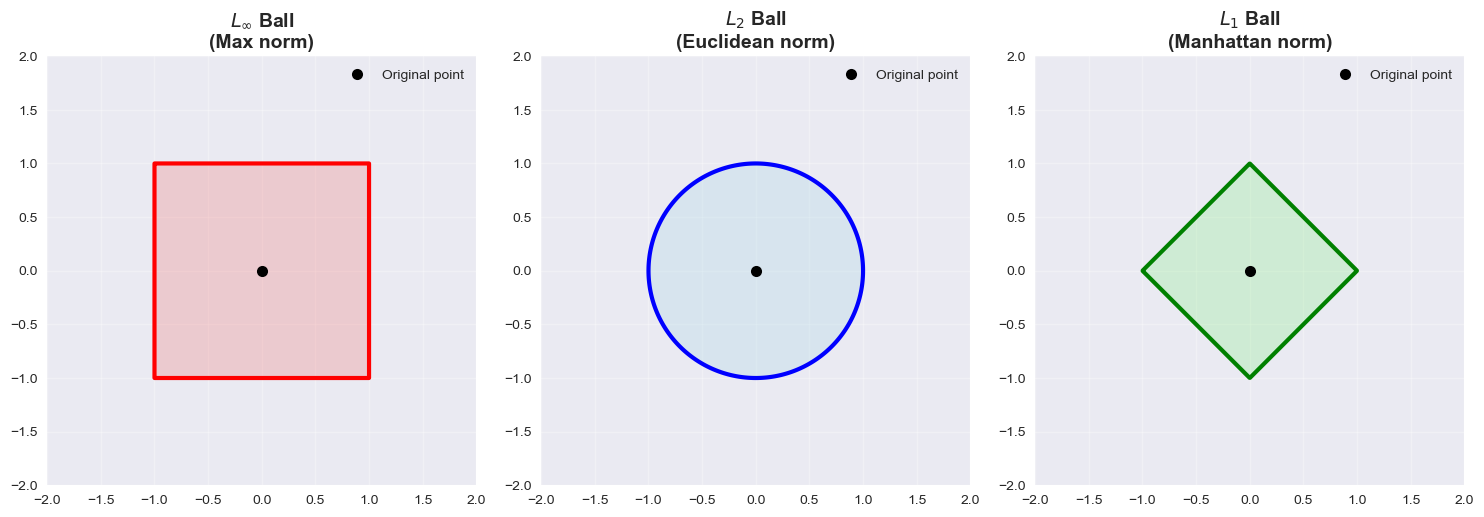

🎯 Epsilon balls for different norms:
• L∞ (red): Square constraint - limits maximum change in any dimension
• L₂ (blue): Circular constraint - limits Euclidean distance
• L₁ (green): Diamond constraint - limits sum of absolute changes

💡 Most adversarial attacks use L∞ because it's perceptually meaningful for images!


In [5]:
# Visualize different L_p norms and epsilon balls
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Create a grid for visualization
x = np.linspace(-2, 2, 1000)
y = np.linspace(-2, 2, 1000)
X, Y = np.meshgrid(x, y)

epsilon = 1.0

# L_infinity norm (max norm)
L_inf = np.maximum(np.abs(X), np.abs(Y))
axes[0].contour(X, Y, L_inf, levels=[epsilon], colors='red', linewidths=3)
axes[0].contourf(X, Y, L_inf, levels=[0, epsilon], colors=['lightcoral'], alpha=0.3)
axes[0].set_title('$L_\infty$ Ball\n(Max norm)', fontsize=14, fontweight='bold')
axes[0].set_xlim(-2, 2)
axes[0].set_ylim(-2, 2)
axes[0].grid(True, alpha=0.3)
axes[0].set_aspect('equal')
axes[0].plot(0, 0, 'ko', markersize=8, label='Original point')
axes[0].legend()

# L_2 norm (Euclidean norm)
L_2 = np.sqrt(X**2 + Y**2)
axes[1].contour(X, Y, L_2, levels=[epsilon], colors='blue', linewidths=3)
axes[1].contourf(X, Y, L_2, levels=[0, epsilon], colors=['lightblue'], alpha=0.3)
axes[1].set_title('$L_2$ Ball\n(Euclidean norm)', fontsize=14, fontweight='bold')
axes[1].set_xlim(-2, 2)
axes[1].set_ylim(-2, 2)
axes[1].grid(True, alpha=0.3)
axes[1].set_aspect('equal')
axes[1].plot(0, 0, 'ko', markersize=8, label='Original point')
axes[1].legend()

# L_1 norm (Manhattan norm)
L_1 = np.abs(X) + np.abs(Y)
axes[2].contour(X, Y, L_1, levels=[epsilon], colors='green', linewidths=3)
axes[2].contourf(X, Y, L_1, levels=[0, epsilon], colors=['lightgreen'], alpha=0.3)
axes[2].set_title('$L_1$ Ball\n(Manhattan norm)', fontsize=14, fontweight='bold')
axes[2].set_xlim(-2, 2)
axes[2].set_ylim(-2, 2)
axes[2].grid(True, alpha=0.3)
axes[2].set_aspect('equal')
axes[2].plot(0, 0, 'ko', markersize=8, label='Original point')
axes[2].legend()

plt.tight_layout()
plt.show()

print("🎯 Epsilon balls for different norms:")
print("• L∞ (red): Square constraint - limits maximum change in any dimension")
print("• L₂ (blue): Circular constraint - limits Euclidean distance")
print("• L₁ (green): Diamond constraint - limits sum of absolute changes")
print("\n💡 Most adversarial attacks use L∞ because it's perceptually meaningful for images!")

## 1.3 From FGSM to PGD

### Fast Gradient Sign Method (FGSM)

FGSM, introduced by Goodfellow et al. (2014), is the simplest adversarial attack:

$$x_{adv} = x + \epsilon \cdot \text{sign}(\nabla_x \mathcal{L}(f(x), y))$$

**Key idea**: Take one step in the direction of the gradient sign with step size $\epsilon$.

### Iterative FGSM (I-FGSM)

Apply FGSM multiple times with smaller steps:

$$x_{adv}^{(t+1)} = \text{Clip}_{x,\epsilon}\left(x_{adv}^{(t)} + \alpha \cdot \text{sign}(\nabla_{x_{adv}^{(t)}} \mathcal{L}(f(x_{adv}^{(t)}), y))\right)$$

Where $\text{Clip}_{x,\epsilon}$ projects back to the epsilon ball around $x$.

### Projected Gradient Descent (PGD)

PGD is essentially I-FGSM with **random initialization**:

1. **Initialize**: $x_{adv}^{(0)} = x + \text{Uniform}(-\epsilon, \epsilon)$
2. **Iterate**: $x_{adv}^{(t+1)} = \Pi_{x,\epsilon}\left(x_{adv}^{(t)} + \alpha \cdot \text{sign}(\nabla_{x_{adv}^{(t)}} \mathcal{L}(f(x_{adv}^{(t)}), y))\right)$

Where $\Pi_{x,\epsilon}$ is the projection operator onto the epsilon ball.

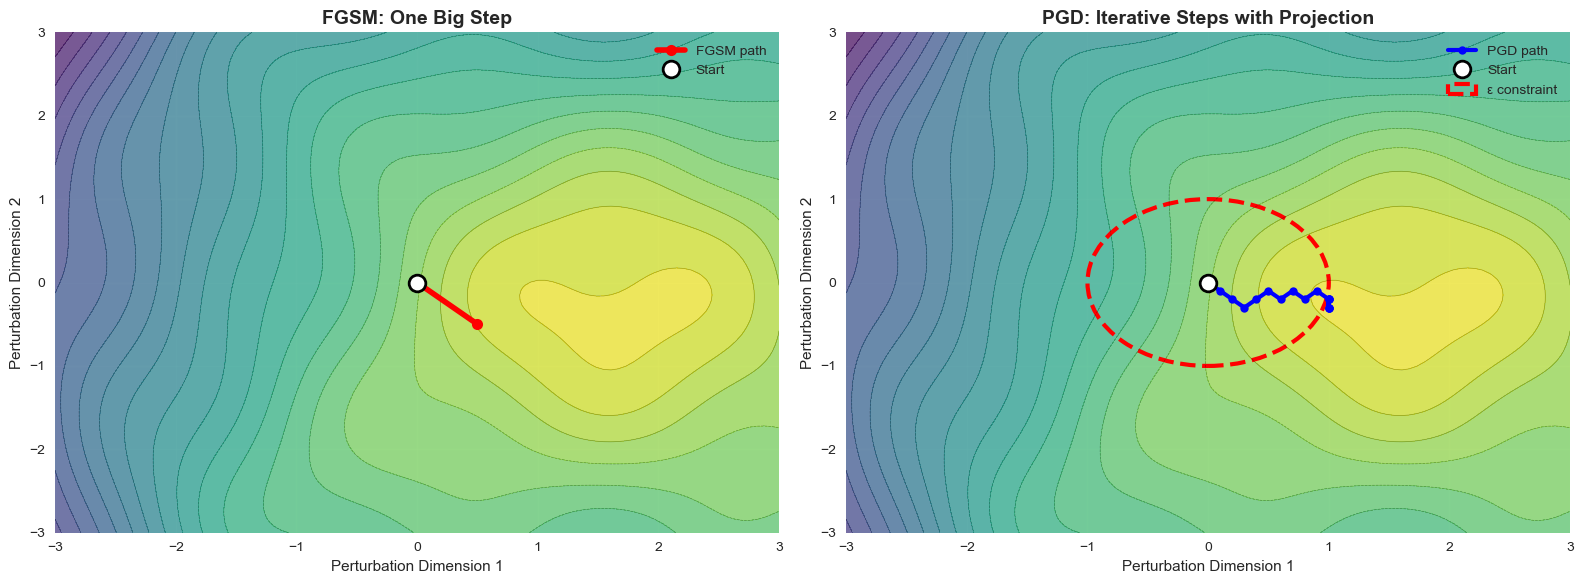

🎯 Key Differences:
• FGSM: Single large step - might get stuck in poor local optima
• PGD: Multiple small steps - better exploration of the loss landscape
• PGD: Projection keeps perturbation within epsilon ball


In [6]:
# Visualize the difference between FGSM and PGD attack trajectories
def create_loss_landscape():
    """Create a synthetic 2D loss landscape for visualization."""
    x = np.linspace(-3, 3, 100)
    y = np.linspace(-3, 3, 100)
    X, Y = np.meshgrid(x, y)
    
    # Create a more complex loss landscape with multiple local maxima
    Z = (np.sin(X) * np.cos(Y) + 0.3 * np.sin(3*X) * np.cos(2*Y) + 
         0.2 * X**2 + 0.1 * Y**2 - 0.5 * (X-1)**2 - 0.3 * (Y+0.5)**2)
    
    return X, Y, Z

def simulate_attack_trajectory(start_x, start_y, attack_type='PGD', steps=10, step_size=0.1):
    """Simulate attack trajectory on the loss landscape."""
    trajectory_x = [start_x]
    trajectory_y = [start_y]
    
    current_x, current_y = start_x, start_y
    
    for step in range(steps):
        # Compute approximate gradient (finite difference)
        h = 0.01
        grad_x = (loss_func(current_x + h, current_y) - loss_func(current_x - h, current_y)) / (2 * h)
        grad_y = (loss_func(current_x, current_y + h) - loss_func(current_x, current_y - h)) / (2 * h)
        
        if attack_type == 'FGSM' and step == 0:
            # FGSM: one big step
            current_x += 0.5 * np.sign(grad_x)
            current_y += 0.5 * np.sign(grad_y)
        elif attack_type == 'PGD':
            # PGD: iterative small steps
            current_x += step_size * np.sign(grad_x)
            current_y += step_size * np.sign(grad_y)
            
            # Project back to epsilon ball (L_infinity)
            epsilon = 1.0
            current_x = np.clip(current_x, start_x - epsilon, start_x + epsilon)
            current_y = np.clip(current_y, start_y - epsilon, start_y + epsilon)
        
        trajectory_x.append(current_x)
        trajectory_y.append(current_y)
        
        if attack_type == 'FGSM':
            break  # FGSM is just one step
    
    return trajectory_x, trajectory_y

def loss_func(x, y):
    """Synthetic loss function."""
    return (np.sin(x) * np.cos(y) + 0.3 * np.sin(3*x) * np.cos(2*y) + 
            0.2 * x**2 + 0.1 * y**2 - 0.5 * (x-1)**2 - 0.3 * (y+0.5)**2)

# Create visualization
X, Y, Z = create_loss_landscape()
start_point = (0, 0)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# FGSM visualization
contour1 = axes[0].contourf(X, Y, Z, levels=20, cmap='viridis', alpha=0.7)
axes[0].contour(X, Y, Z, levels=20, colors='black', alpha=0.3, linewidths=0.5)

# FGSM trajectory
fgsm_x, fgsm_y = simulate_attack_trajectory(start_point[0], start_point[1], 'FGSM')
axes[0].plot(fgsm_x, fgsm_y, 'r-', linewidth=4, marker='o', markersize=8, label='FGSM path')
axes[0].plot(start_point[0], start_point[1], 'wo', markersize=12, markeredgecolor='black', 
             markeredgewidth=2, label='Start')

axes[0].set_title('FGSM: One Big Step', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Perturbation Dimension 1')
axes[0].set_ylabel('Perturbation Dimension 2')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# PGD visualization
contour2 = axes[1].contourf(X, Y, Z, levels=20, cmap='viridis', alpha=0.7)
axes[1].contour(X, Y, Z, levels=20, colors='black', alpha=0.3, linewidths=0.5)

# PGD trajectory
pgd_x, pgd_y = simulate_attack_trajectory(start_point[0], start_point[1], 'PGD', steps=15)
axes[1].plot(pgd_x, pgd_y, 'b-', linewidth=3, marker='o', markersize=6, label='PGD path')
axes[1].plot(start_point[0], start_point[1], 'wo', markersize=12, markeredgecolor='black', 
             markeredgewidth=2, label='Start')

# Show epsilon constraint
circle = plt.Circle(start_point, 1.0, fill=False, color='red', linewidth=3, linestyle='--', 
                   label='ε constraint')
axes[1].add_patch(circle)

axes[1].set_title('PGD: Iterative Steps with Projection', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Perturbation Dimension 1')
axes[1].set_ylabel('Perturbation Dimension 2')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("🎯 Key Differences:")
print("• FGSM: Single large step - might get stuck in poor local optima")
print("• PGD: Multiple small steps - better exploration of the loss landscape")
print("• PGD: Projection keeps perturbation within epsilon ball")

## 1.4 Interactive Parameter Exploration

Let's create an interactive widget to explore how different parameters affect PGD attacks!

In [ ]:
# Interactive exploration of PGD parameters
@interact(epsilon=(0.01, 0.5, 0.01), 
          alpha=(0.001, 0.1, 0.001), 
          iterations=(1, 50, 1),
          random_start=[True, False])
def explore_pgd_parameters(epsilon=0.03, alpha=0.01, iterations=10, random_start=True):
    """
    Interactive exploration of PGD parameters.
    
    Args:
        epsilon: Maximum perturbation magnitude (L_infinity norm)
        alpha: Step size for each iteration
        iterations: Number of PGD iterations
        random_start: Whether to use random initialization
    """
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Left plot: Parameter summary
    axes[0].text(0.1, 0.9, f"PGD Parameters:", fontsize=16, fontweight='bold', transform=axes[0].transAxes)
    axes[0].text(0.1, 0.8, f"• Epsilon (ε): {epsilon:.3f}", fontsize=14, transform=axes[0].transAxes)
    axes[0].text(0.1, 0.7, f"• Alpha (α): {alpha:.3f}", fontsize=14, transform=axes[0].transAxes)
    axes[0].text(0.1, 0.6, f"• Iterations: {iterations}", fontsize=14, transform=axes[0].transAxes)
    axes[0].text(0.1, 0.5, f"• Random start: {random_start}", fontsize=14, transform=axes[0].transAxes)
    
    # Calculate some metrics
    max_perturbation = epsilon
    total_steps = alpha * iterations
    
    axes[0].text(0.1, 0.3, f"Derived Metrics:", fontsize=16, fontweight='bold', transform=axes[0].transAxes)
    axes[0].text(0.1, 0.2, f"• Max L∞ perturbation: {max_perturbation:.3f}", fontsize=14, transform=axes[0].transAxes)
    axes[0].text(0.1, 0.1, f"• Total step distance: {total_steps:.3f}", fontsize=14, transform=axes[0].transAxes)
    
    # Add recommendations
    if alpha > epsilon / 2:
        axes[0].text(0.1, 0.05, "⚠️  Alpha might be too large!", fontsize=12, color='red', 
                    fontweight='bold', transform=axes[0].transAxes)
    elif total_steps > epsilon * 10:
        axes[0].text(0.1, 0.05, "💡 Many iterations - thorough exploration", fontsize=12, color='blue', 
                    fontweight='bold', transform=axes[0].transAxes)
    else:
        axes[0].text(0.1, 0.05, "✅ Parameters look good!", fontsize=12, color='green', 
                    fontweight='bold', transform=axes[0].transAxes)
    
    axes[0].set_xlim(0, 1)
    axes[0].set_ylim(0, 1)
    axes[0].set_title('Parameter Analysis', fontsize=14, fontweight='bold')
    axes[0].axis('off')
    
    # Right plot: Simulated attack strength vs. parameter values
    epsilons = np.linspace(0.01, 0.5, 50)
    # Simulate attack success rate (this is a toy model)
    success_rates = 1 - np.exp(-epsilons * 10)  # Exponential saturation
    
    axes[1].plot(epsilons, success_rates, 'b-', linewidth=2, label='Simulated Success Rate')
    axes[1].axvline(epsilon, color='red', linestyle='--', linewidth=2, 
                   label=f'Current ε = {epsilon:.3f}')
    axes[1].axhline(1 - np.exp(-epsilon * 10), color='red', linestyle=':', alpha=0.7)
    
    axes[1].set_xlabel('Epsilon (ε)')
    axes[1].set_ylabel('Simulated Attack Success Rate')
    axes[1].set_title('Attack Strength vs. Epsilon', fontsize=14, fontweight='bold')
    axes[1].grid(True, alpha=0.3)
    axes[1].legend()
    axes[1].set_ylim(0, 1)
    
    plt.tight_layout()
    plt.show()
    
    # Provide insights based on parameters
    print("\n🔍 Parameter Insights:")
    
    if epsilon < 0.05:
        print(f"• Small ε ({epsilon:.3f}) → Subtle perturbations, may be harder to detect")
    elif epsilon > 0.2:
        print(f"• Large ε ({epsilon:.3f}) → Strong perturbations, more likely to succeed but detectable")
    
    if alpha > epsilon / iterations:
        print(f"• Large α relative to ε/iterations → Risk of overshooting")
    else:
        print(f"• Appropriate α → Good balance between progress and stability")
    
    if iterations < 5:
        print(f"• Few iterations ({iterations}) → Fast but might not find optimal adversarial examples")
    elif iterations > 40:
        print(f"• Many iterations ({iterations}) → Thorough but computationally expensive")
    
    if random_start:
        print(f"• Random start → Better exploration, escapes poor local optima")
    else:
        print(f"• No random start → Deterministic but might get stuck in poor solutions")

interactive(children=(FloatSlider(value=0.03, description='epsilon', max=0.5, min=0.01, step=0.01), FloatSlide…

## 1.5 Key Concepts Summary

### 🎯 What We've Learned:

1. **Adversarial Examples**: Small perturbations that fool ML models while remaining imperceptible to humans

2. **Mathematical Foundation**: 
   - Optimization problem: maximize loss subject to perturbation constraints
   - Different norms ($L_\infty$, $L_2$, $L_1$) define different constraint shapes

3. **Attack Evolution**:
   - **FGSM**: Single step in gradient direction
   - **I-FGSM**: Multiple small steps
   - **PGD**: I-FGSM with random initialization (stronger!)

4. **Key Parameters**:
   - **Epsilon (ε)**: Maximum perturbation magnitude
   - **Alpha (α)**: Step size per iteration
   - **Iterations**: Number of optimization steps
   - **Random start**: Helps escape poor local optima

### 🛡️ Why This Matters for Security:

- **Understanding vulnerabilities** helps build more robust models
- **Red team/blue team** approach: attack to defend
- **Evaluation methodology** for ML security
- **Awareness** of potential threats in production systems

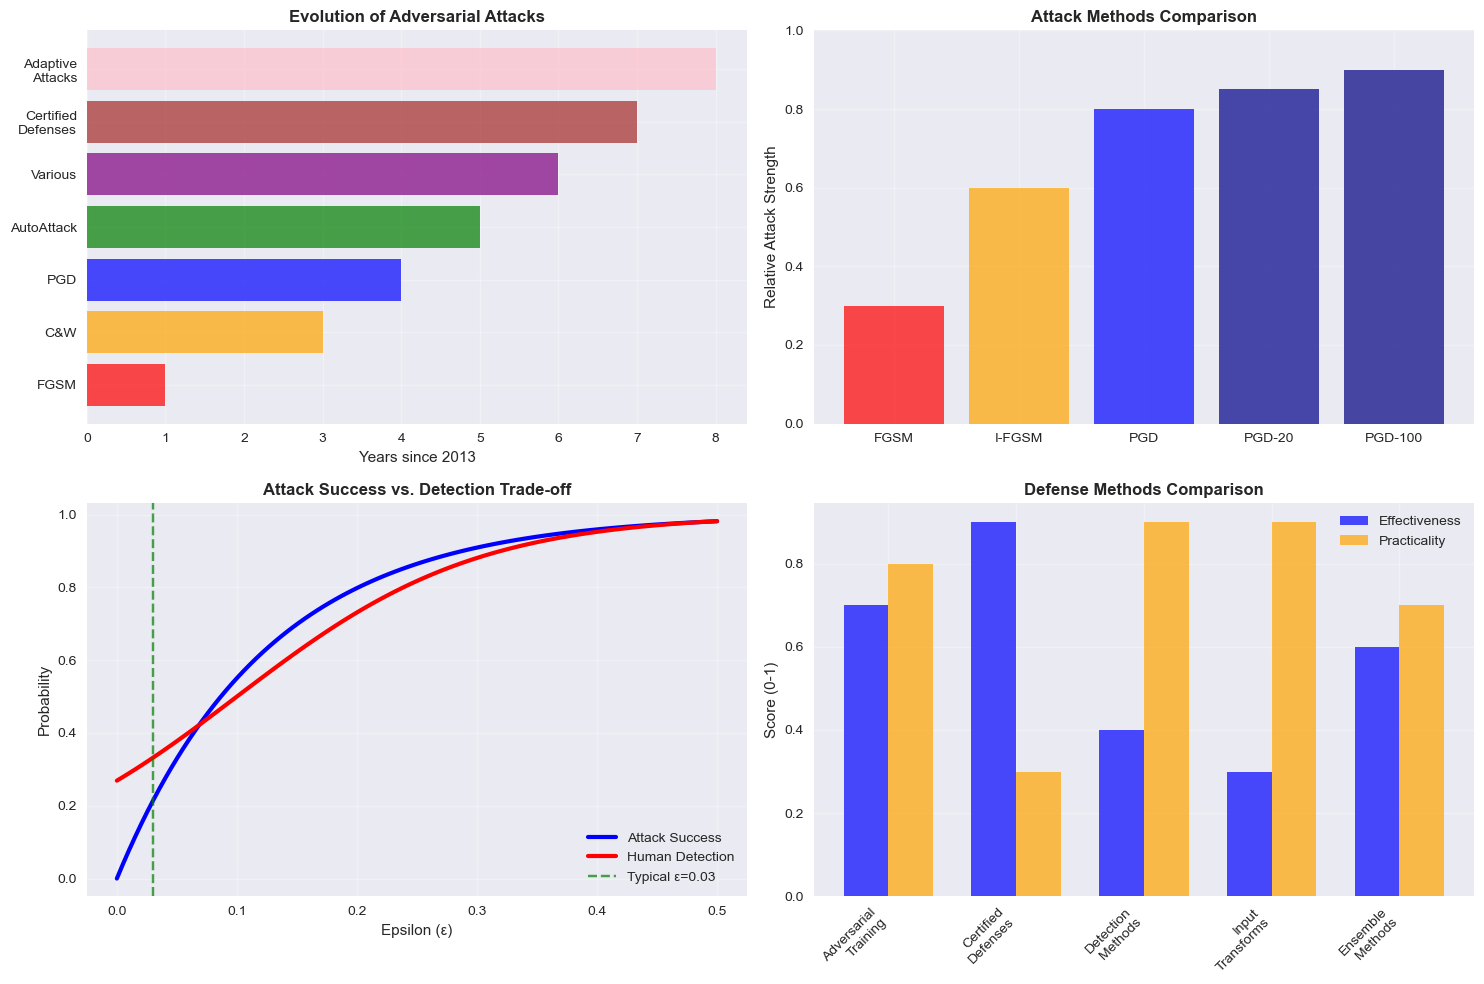

📚 Summary:
• Adversarial ML is an active research area with constant evolution
• PGD represents a significant improvement over FGSM
• There's a fundamental trade-off between attack strength and detectability
• Multiple defense strategies exist, each with pros and cons

🎯 Next: Let's implement PGD from scratch in the next notebook!


In [8]:
# Create a final summary visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Timeline of adversarial attacks
years = [2014, 2016, 2017, 2018, 2019, 2020, 2021]
attacks = ['FGSM', 'C&W', 'PGD', 'AutoAttack', 'Various', 'Certified\nDefenses', 'Adaptive\nAttacks']
colors = ['red', 'orange', 'blue', 'green', 'purple', 'brown', 'pink']

axes[0,0].barh(attacks, [y-2013 for y in years], color=colors, alpha=0.7)
axes[0,0].set_xlabel('Years since 2013')
axes[0,0].set_title('Evolution of Adversarial Attacks', fontweight='bold')
axes[0,0].grid(True, alpha=0.3)

# Attack strength comparison
attack_names = ['FGSM', 'I-FGSM', 'PGD', 'PGD-20', 'PGD-100']
strength = [0.3, 0.6, 0.8, 0.85, 0.9]
colors = ['red', 'orange', 'blue', 'darkblue', 'navy']

axes[0,1].bar(attack_names, strength, color=colors, alpha=0.7)
axes[0,1].set_ylabel('Relative Attack Strength')
axes[0,1].set_title('Attack Methods Comparison', fontweight='bold')
axes[0,1].set_ylim(0, 1)
axes[0,1].grid(True, alpha=0.3)

# Epsilon vs. perceptibility trade-off
epsilon_vals = np.linspace(0, 0.5, 100)
attack_success = 1 - np.exp(-epsilon_vals * 8)
human_detection = 1 / (1 + np.exp(-10 * (epsilon_vals - 0.1)))

axes[1,0].plot(epsilon_vals, attack_success, 'b-', linewidth=3, label='Attack Success')
axes[1,0].plot(epsilon_vals, human_detection, 'r-', linewidth=3, label='Human Detection')
axes[1,0].axvline(0.03, color='green', linestyle='--', alpha=0.7, label='Typical ε=0.03')
axes[1,0].set_xlabel('Epsilon (ε)')
axes[1,0].set_ylabel('Probability')
axes[1,0].set_title('Attack Success vs. Detection Trade-off', fontweight='bold')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# Defense strategies
defenses = ['Adversarial\nTraining', 'Certified\nDefenses', 'Detection\nMethods', 'Input\nTransforms', 'Ensemble\nMethods']
effectiveness = [0.7, 0.9, 0.4, 0.3, 0.6]
practicality = [0.8, 0.3, 0.9, 0.9, 0.7]

x = np.arange(len(defenses))
width = 0.35

axes[1,1].bar(x - width/2, effectiveness, width, label='Effectiveness', alpha=0.7, color='blue')
axes[1,1].bar(x + width/2, practicality, width, label='Practicality', alpha=0.7, color='orange')
axes[1,1].set_ylabel('Score (0-1)')
axes[1,1].set_title('Defense Methods Comparison', fontweight='bold')
axes[1,1].set_xticks(x)
axes[1,1].set_xticklabels(defenses, rotation=45, ha='right')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("📚 Summary:")
print("• Adversarial ML is an active research area with constant evolution")
print("• PGD represents a significant improvement over FGSM")
print("• There's a fundamental trade-off between attack strength and detectability")
print("• Multiple defense strategies exist, each with pros and cons")
print("\n🎯 Next: Let's implement PGD from scratch in the next notebook!")

## 📝 Exercises for Students

### Exercise 1: Parameter Analysis
Using the interactive widget above, explore different parameter combinations and answer:
1. What happens when α > ε?
2. How does the number of iterations affect attack quality?
3. Why is random start important for PGD?

### Exercise 2: Norm Understanding
1. Explain why L∞ norm is commonly used for image adversarial examples
2. In what scenarios might L₂ norm be more appropriate?
3. Draw the epsilon ball for L₀ norm (hint: it's neither continuous nor convex)

### Exercise 3: Attack Comparison
1. List three advantages of PGD over FGSM
2. When might FGSM be preferable to PGD?
3. Propose a modification to PGD that could make it even stronger

### Exercise 4: Ethical Considerations
1. List three legitimate uses of adversarial attack research
2. What are potential misuses of this technology?
3. How can we ensure responsible research and deployment?

---

## 🎯 Next Steps

In the next notebook (`02_pgd_implementation.ipynb`), we will:
- Implement PGD from scratch in PyTorch
- Test it on real neural networks and images
- Visualize attack progression step by step
- Compare different attack variants

**Ready to get your hands dirty with code? Let's go! 🚀**